### Project 3 Collaborative Filtering

In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
rating = pd.read_csv('./ratings.csv')
movies = pd.read_csv('./movies.csv')
links = pd.read_csv('./links.csv')
tags = pd.read_csv('./tags.csv')

### QUESTION 1: Compute the sparsity of the movie rating dataset, where sparsity is defined by

Sparsity = Total number of available ratings / Total number of possible ratings (1)

In [3]:
df = rating
df.shape

(100836, 4)

In [20]:
df.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [68]:
#ratings matrix
r_matrix = df.pivot(index = 'userId', columns = 'movieId', values = 'rating')

In [22]:
print(r_matrix.shape)

(610, 9724)


In [185]:
sparsity = df.rating.count()*1.0/(r_matrix.shape[0] * r_matrix.shape[1]) #count() avoids NaN
print('Sparsity of rating dataset is', sparsity)

#count_row = df.shape[0]  # Gives number of rows
#count_col = df.shape[1]  # Gives number of columns

Sparsity of rating dataset is 0.016999683055613623


### Plot a histogram showing the frequency of the rating values.

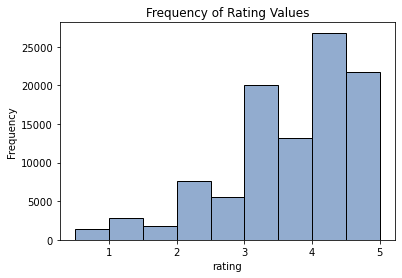

In [121]:
sns.color_palette("pastel", as_cmap=True)
ax = sns.histplot(data=df, x="rating", binwidth=0.5)
ax.set_title('Frequency of Rating Values')
ax.set_ylabel('Frequency');

Most of the ratings are between 3 and 5 - users from this sample

### QUESTION 3: Plot the distribution of the number of ratings received among movies.

In [70]:
r_dist = r_matrix.count().sort_values(ascending=False).reset_index()
r_dist.columns = ['movieId', 'count']

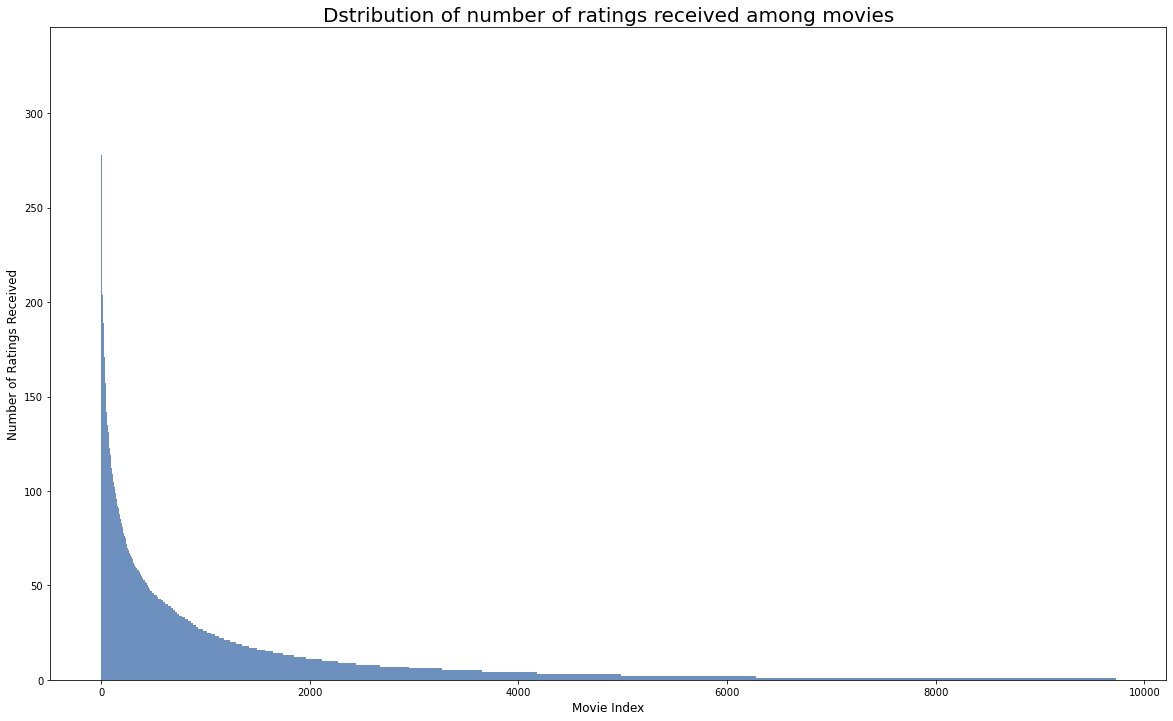

In [193]:
plt.figure(figsize=(20, 12))
plt.bar(r_dist.index, r_dist['count'], width=1)
plt.title('Dstribution of number of ratings received among movies',fontsize= 20)
plt.xlabel('Movie Index',fontsize= 12)
plt.ylabel('Number of Ratings Received',fontsize= 12)
plt.show()

### Q4 Plot the distribution of ratings among users

In [134]:
u_dist = r_matrix.notna().sum(axis=1).sort_values(ascending=False).reset_index()
u_dist.columns = ['userId', 'count']

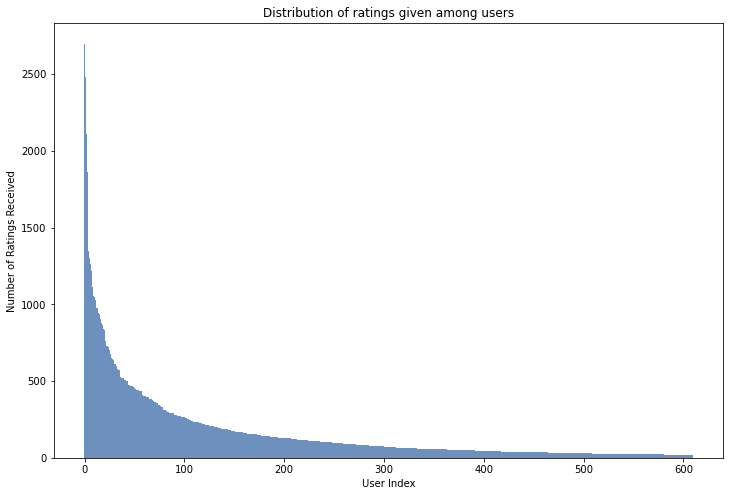

In [197]:
plt.figure(figsize=(12, 8))
plt.bar(u_dist.index, u_dist['count'], width=1)
plt.title('Distribution of ratings given among users')
plt.xlabel('User Index')
plt.ylabel('Number of Ratings Received')
plt.show()

### QUESTION 5: Explain the salient features of the distribution found in question 3 and their implications for the recommendation process.


This indicates that both ratings received per movie and ratings per user have lots of long tail data. Namely, only very few movie, say less than 10% received high volume of ratings and only very few users provide high volume of ratings. Most movies only have very few ratings and most users only have very few ratings. 

Movies in the right side of graph are less rated than the those in left side. This means that there are much more sparsity or unobserved areas for those items in ratings matrix. This can cause a recommender system which relies on neighborhood algorithms produce bad results.

### QUESTION 6: Compute the variance of the rating values received by each movie.

In [ ]:
var_movie = np.var(r_matrix, axis=0)
var_movie.max()

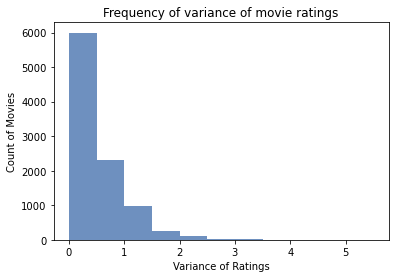

In [228]:
plt.hist(var_movie, bins=[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5]) #bins=np.arange(5.5, step=0.5)
plt.title('Frequency of variance of movie ratings')
plt.xlabel('Variance of Ratings')
plt.ylabel('Count of Movies')
plt.show()

### QUESTION 16: Is the optimization problem given by equation 5 convex? 
Consider the optimization problem given by equation 5. For U fixed, formulate it as a least-squares problem.

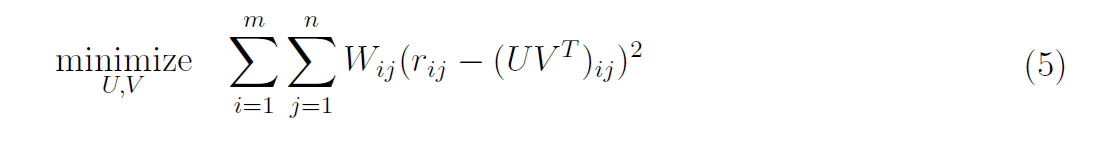

### QUESTION 17: Design a NNMF-based collaborative filter to predict the ratings of the movies in the MovieLens dataset and evaluate it's performance using 10-fold cross-validation.

In [4]:
from surprise.prediction_algorithms.matrix_factorization import NMF
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise import accuracy

In [5]:
df = pd.read_csv('./ratings.csv')
reader = Reader(rating_scale=(1,5))
rating_df=Dataset.load_from_df(df[['userId', 'movieId', 'rating']],reader)

In [8]:
#Question 17
nfold = 10
k = np.arange(2, 52, 2)

meanMAE=[]
meanRMSE=[]

for k in k:
    algo = NMF(n_factors=k)
    ans = cross_validate(algo, rating_df, measures=['RMSE', 'MAE'], cv=nfold, verbose=False)
    meanMAE.append(np.mean(ans.get('test_mae')))
    meanRMSE.append(np.mean(ans.get('test_rmse')))

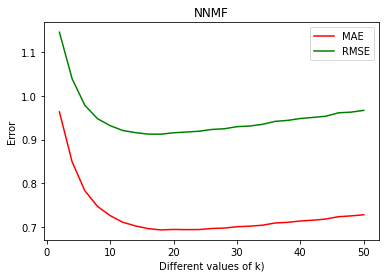

In [10]:
plt.plot(range(2,52,2), meanMAE, 'r', label='MAE')
plt.plot(range(2,52,2), meanRMSE, 'g', label='RMSE')
plt.legend(['MAE','RMSE'])
plt.xlabel('k')
plt.ylabel('Error')
plt.title('NNMF - Mean RMSE and MAE with 10 folds cv')
plt.show()

### Question 18 find optimal latent factor

In [74]:
print('the min meanMAE is', min(meanMAE))
print('the min meanRMSE is', min(meanRMSE))
print('Based on the plot, the optimal latent factors is around 18-20 based on the min average MAE/RMSE')

the min meanMAE is 0.6937866084129313
the min meanRMSE is 0.9124172817280524
Based on the plot, the optimal latent factors is around 18-20 based on the min average MAE/RMSE


In [75]:
# Count Genres Functions
len(pd.unique(movies["genres"].str.split("|", expand=True).stack()))
print('The optimal latent factor k is very close to the movie genres count of 20.')

The optimal latent factor k is very close to the movie genres count of 20.


### Question 19 - 20 Design a NNMF collaborative filter to predict the ratings of the movies in the popular/unpopular movie trimmed test set and evaluate it's performance using 10-fold cross validation.

In [73]:
#popular vs unpopular
popular_movieId = list(r_dist['movieId'][r_dist['count'] > 2])
unpopular_movieId = list(r_dist['movieId'][r_dist['count'] <= 2])

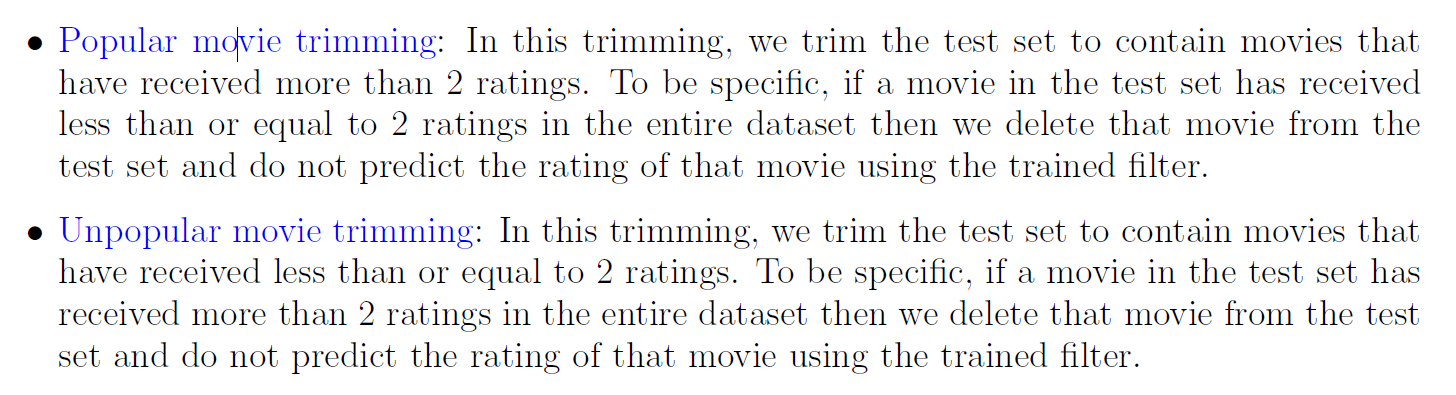

In [76]:
# create functions for popular/unpopular test dataset:
def popular_movie_trim(testset):
  trim_test = []
  for i in range(len(testset)):
    if int(testset[i][1]) in unpopular_movieId:
      trim_test.append(testset[i])
  return trim_test

def unpopular_movie_trim(testset):
  trim_test = []
  for i in range(len(testset)):
    if int(testset[i][1]) in unpopular_movieId:
      trim_test.append(testset[i])
  return trim_test

In [ ]:
from surprise.model_selection import KFold
from surprise import accuracy

popularMAE=[]
popularRMSE=[]

for k in range(2,51,2):
    algo=NMF(n_factors=k)
    kf = KFold(n_splits=10)
    rmse=[]
    mae=[]
    print ("Running for k = ",k)
    for trainset, testset in kf.split(rating_df):
        
    # train and test
        algo.fit(trainset)
        testset=popular_movie_trim(testset)
        predictions = algo.test(testset)
        
    # evaluate performance
        rmse.append(accuracy.rmse(predictions, verbose=False))
        mae.append(accuracy.mae(predictions, verbose=False))
        
        popularMAE.append(np.mean(mae))
        popularRMSE.append(np.mean(rmse))

Running for k =  2
Running for k =  4
Running for k =  6
Running for k =  8
Running for k =  10
Running for k =  12
Running for k =  14
Running for k =  16
Running for k =  18
Running for k =  20
Running for k =  22
Running for k =  24
Running for k =  26
Running for k =  28
Running for k =  30


In [ ]:
plt.plot(range(2,51,2),popularMAE,'r',label='MAE')
plt.plot(range(2,51,2),popularRMSE,'g',label='RMSE')
plt.legend(['MAE','RMSE'])
plt.xlabel('k)')
plt.ylabel('Error')
plt.title('NNMF with popular movie trimming ')
plt.show()

In [ ]:
#Question 20
#unpopular ones
from surprise.model_selection import KFold
from surprise import accuracy

unpopularMAE=[]
unpopularRMSE=[]

for k in range(2,51,2):
    algo=NMF(n_factors=k)
    kf = KFold(n_splits=10)
    rmse=[]
    mae=[]
    print ("Running for k = ",k)
    for trainset, testset in kf.split(rating_df):
        
    # train and test
        algo.fit(trainset)
        testset=unpopular_movie_trim(testset)
        predictions = algo.test(testset)
        
    # evaluate performance
        rmse.append(accuracy.rmse(predictions, verbose=False))
        mae.append(accuracy.mae(predictions, verbose=False))
        
        unpopularMAE.append(np.mean(mae))
        unpopularRMSE.append(np.mean(rmse))

In [ ]:
plt.plot(range(2,51,2),unpopularMAE,'r',label='MAE')
plt.plot(range(2,51,2),unpopularRMSE,'g',label='RMSE')
plt.legend(['MAE','RMSE'])
plt.xlabel('k)')
plt.ylabel('Error')
plt.title('NNMF with unpopular movie trimming')
plt.show()

### Question 21: Design a NNMF collaborative filter to predict the ratings of the movies in the high variance movie trimmed test set and evaluate it's performance using 10-fold cross validation.

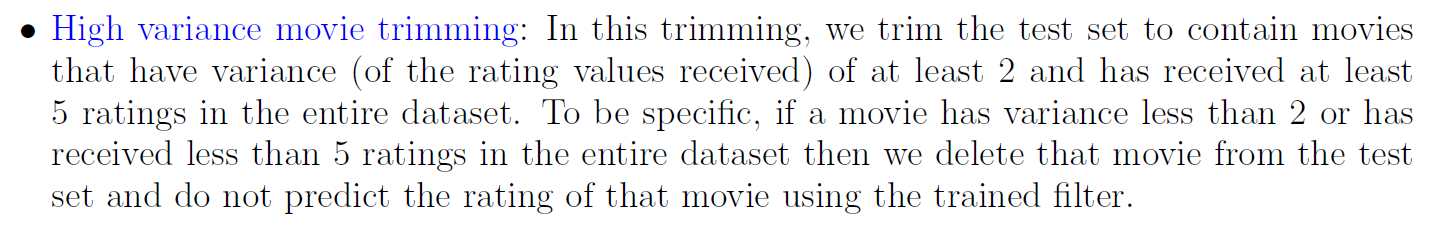

In [ ]:
high_var = pd.concat([pd.DataFrame(var_movie), pd.DataFrame(r_matrix.count())], axis=1).reset_index()
high_var.columns = ['movieId', 'variance', 'count']

In [ ]:
highvar_movieId = list(high_var['movieId'][(high_var['variance'] >= 2) & (high_var['count'] >= 5)])

In [ ]:
def highvar_movie_trim(testset):
  trim_test = []
  for i in range(len(testset)):
    if int(testset[i][1]) in unpopular_movieId:
      trim_test.append(testset[i])
  return trim_test

In [ ]:
#Question 21
#highvar movies
from surprise.model_selection import KFold
from surprise import accuracy

highvarMAE=[]
highvarRMSE=[]

for k in range(2,51,2):
    algo=NMF(n_factors=k)
    kf = KFold(n_splits=10)
    rmse=[]
    mae=[]
    print ("Running for k = ",k)
    for trainset, testset in kf.split(rating_df):
        
    # train and test
        algo.fit(trainset)
        testset=highvar_movie_trim(testset)
        predictions = algo.test(testset)
        
    # evaluate performance
        rmse.append(accuracy.rmse(predictions, verbose=False))
        mae.append(accuracy.mae(predictions, verbose=False))
        
        highvarMAE.append(np.mean(mae))
        highvarRMSE.append(np.mean(rmse))